# Notebook that Retreives and Processes SWE Data 
Data available from https://daacdata.apps.nsidc.org/pub/DATASETS/nsidc0719_SWE_Snow_Depth_v1/"
Data documentation available at https://nsidc.org/data/nsidc-0719/versions/1

# Step 0 Configure Notebook

In [1]:
import earthaccess
import numpy as np
import netCDF4
import xarray as xr
import pandas as pd
import polars as pl
import os
import geopandas as gpd
import regionmask
import rasterio
import rioxarray
import folium
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from scipy.io import netcdf

In [2]:
#earthaccess.login(persist=True)

# Step 1 Download Data

In [3]:
# define constants
ROOT = "https://daacdata.apps.nsidc.org/pub/DATASETS/nsidc0719_SWE_Snow_Depth_v1/"

In [4]:
# function that downloads data for a single year 
# returns data as a ds (xarray) object
def download_year(year): 
    f = f"4km_SWE_Depth_WY{year}_v01.nc"
    url = ROOT +f 
    # download the file if not yet available 
    if not os.path.exists(f):
        print(f"downloading file {f} at url {url}")
        !curl -b ~/.urs_cookies -c ~/.urs_cookies -L -n -O {url}
    else:
        print(f"The file {f} already exists, skipping download.")
    ds = xr.open_dataset(f)
    ds.close()
    return ds

In [5]:
# function to inspect SWE values 

def inspect_swe(ds):
    swe_data = ds['SWE']
    total_values = swe_data.size
    na_values = swe_data.isnull().sum().item()  # Convert to scalar
    na_percentage = (na_values / total_values) * 100
    print(f"Total number of SWE values: {total_values}")
    print(f"Number of n/a (NaN) SWE values: {na_values}")
    print(f"Percentage of n/a (NaN) SWE values: {na_percentage:.2f}%")

In [6]:
# Example - download data for one year
YEAR = "2023"
ds = download_year(YEAR)
inspect_swe(ds)
ds

The file 4km_SWE_Depth_WY2023_v01.nc already exists, skipping download.
Total number of SWE values: 318464325
Number of n/a (NaN) SWE values: 147849090
Percentage of n/a (NaN) SWE values: 46.43%


<xarray.Dataset> Size: 3GB
Dimensions:   (lat: 621, lon: 1405, time: 365, time_str_len: 11)
Coordinates:
  * lat       (lat) float32 2kB 24.08 24.12 24.17 24.21 ... 49.83 49.88 49.92
  * lon       (lon) float32 6kB -125.0 -125.0 -124.9 ... -66.58 -66.54 -66.5
  * time      (time) datetime64[ns] 3kB 2022-10-01 2022-10-02 ... 2023-09-30
Dimensions without coordinates: time_str_len
Data variables:
    crs       |S1 1B ...
    time_str  (time_str_len, time) |S1 4kB ...
    SWE       (time, lat, lon) float32 1GB nan nan nan nan ... nan nan nan nan
    DEPTH     (time, lat, lon) float32 1GB ...

# Step 2: Filter the Data 

In [7]:
def crude_filter(ds, min_lon, min_lat, max_lon, max_lat):
    ds = ds[["SWE", "DEPTH"]] # drop unneeded variables
    filtered_ds = ds.sel(lat=slice(min_lat, max_lat), lon=slice(min_lon, max_lon))
    return filtered_ds
    

In [8]:
def fine_filter (ds, shapefile): 
    poly = shapefile.geometry
    ds = ds[["SWE", "DEPTH"]] # drop the timestring and CRS variables as they don't play well with rio
    ds = ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace = True)
    ds = ds.rio.write_crs("EPSG:4326", inplace=True)
    ds_final = ds.rio.clip(poly, ds.rio.crs, drop=True)
    return ds_final

In [9]:
# Example crude filter Skagit valley bounding box for water year 2023
B_BOX = (-122.6,47.5,-120,49.5)  # This is the bounding box for Skagit valley 
filtered_ds = crude_filter(ds, B_BOX[0], B_BOX[1], B_BOX[2], B_BOX[3])
inspect_swe(filtered_ds)
filtered_ds

Total number of SWE values: 1126755
Number of n/a (NaN) SWE values: 360255
Percentage of n/a (NaN) SWE values: 31.97%


<xarray.Dataset> Size: 9MB
Dimensions:  (time: 365, lat: 49, lon: 63)
Coordinates:
  * lat      (lat) float32 196B 47.5 47.54 47.58 47.62 ... 49.42 49.46 49.5
  * lon      (lon) float32 252B -122.6 -122.5 -122.5 ... -120.1 -120.0 -120.0
  * time     (time) datetime64[ns] 3kB 2022-10-01 2022-10-02 ... 2023-09-30
Data variables:
    SWE      (time, lat, lon) float32 5MB 0.0 0.0 nan nan ... nan nan nan nan
    DEPTH    (time, lat, lon) float32 5MB ...

In [10]:
# Example fine filter using Skagit shape file 
# Can optionally use the pre-filtered (crude filtered) dataset as input
boundary_path = "SkagitBoundary.json"
sf = gpd.read_file(str(boundary_path))
filtered_ds = fine_filter(filtered_ds, sf)
inspect_swe(filtered_ds)


Total number of SWE values: 469755
Number of n/a (NaN) SWE values: 293825
Percentage of n/a (NaN) SWE values: 62.55%


That's a lot of n/a values.  What's going on? 

# Step 3 Graph Results 

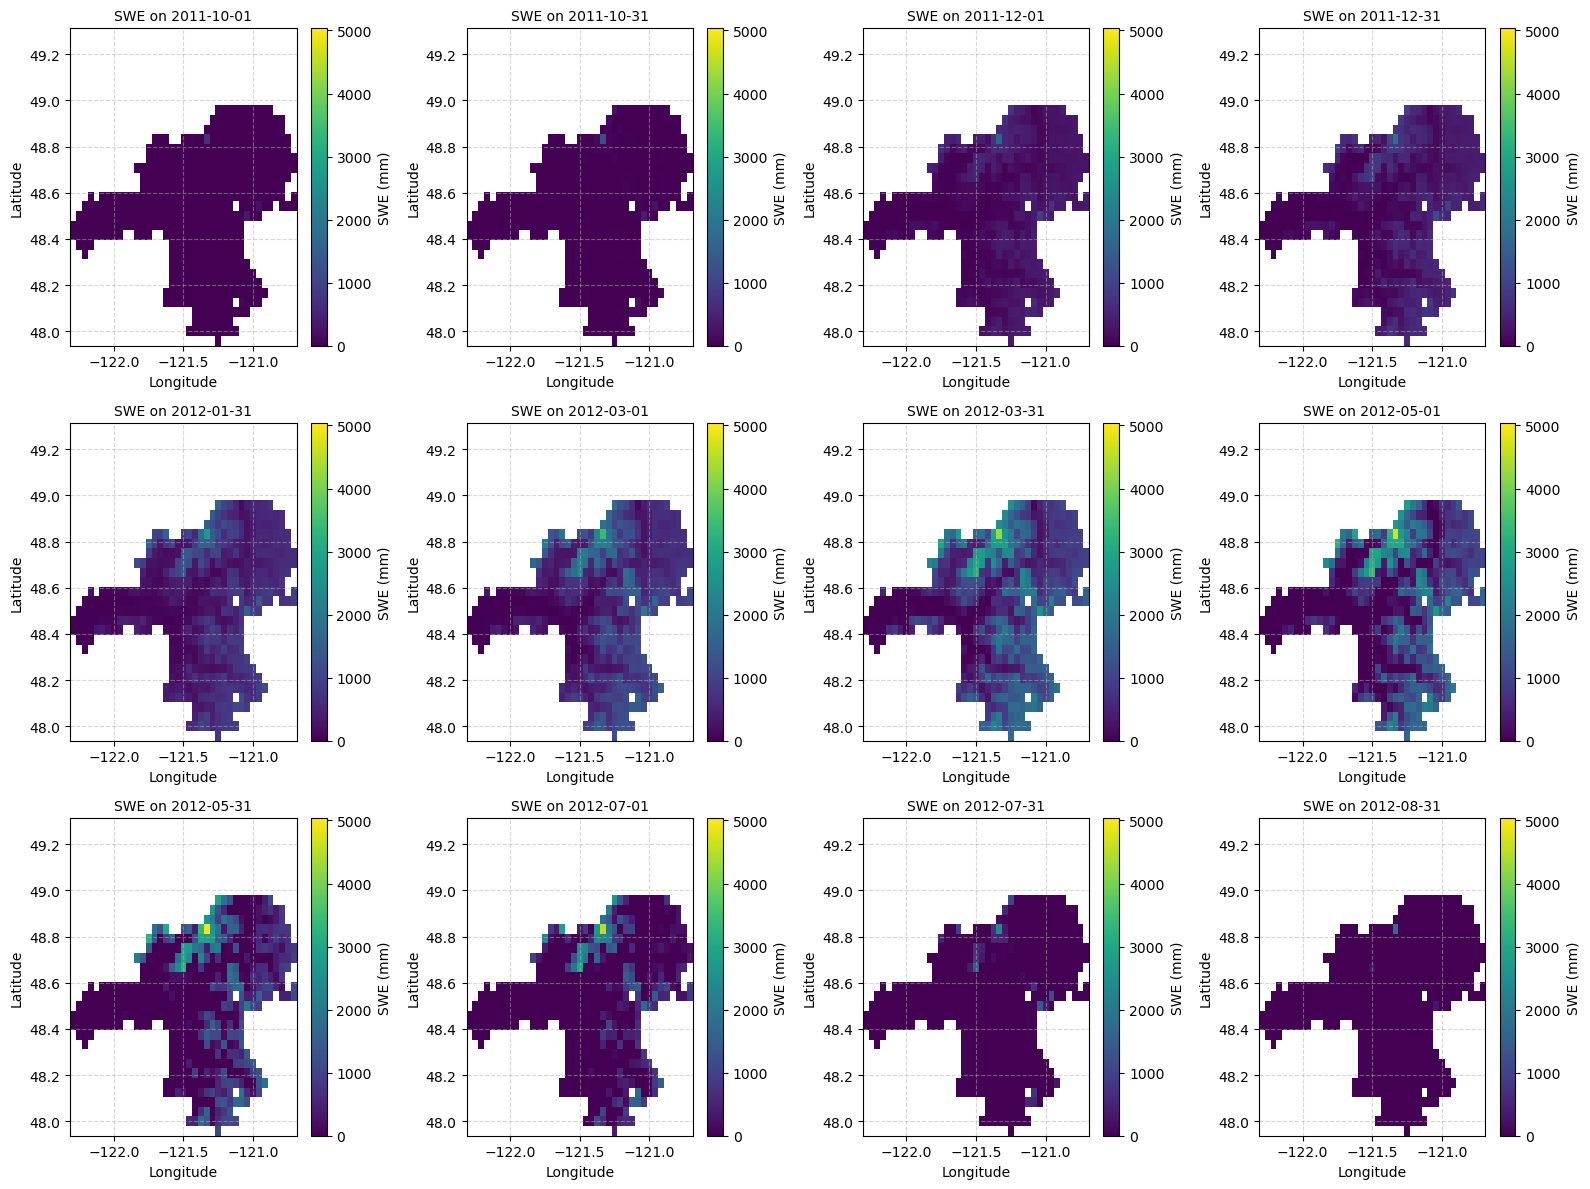

In [22]:
# Graph one year of SWE data 
#Using the example year above 
# Create a 4x3 grid of subplots
fig, axes = plt.subplots(3, 4, figsize=(16, 12))  # Adjust size as needed
axes = axes.flatten()  # Flatten to easily index axes

# Loop to create the plots
for i in range(12):  # Ensure the number of iterations matches the grid size
    swe_data = filtered_ds['SWE']
    time_slice = filtered_ds['time'].isel(time=round(i*365/12))
    swe_slice = filtered_ds['SWE'].sel(time=time_slice)
    swe_min = swe_data.min().values  # Get the minimum value of SWE
    swe_max = swe_data.max().values  # Get the maximum value of SWE
    
    ax = axes[i]  # Get the subplot axis for this iteration
    swe_slice.plot(
        ax=ax,
        x='lon', 
        y='lat', 
        vmin=swe_min,  # Set the minimum value of the colormap
        vmax=swe_max,  # Set the maximum value of the colormap
        cmap='viridis', 
        cbar_kwargs={'label': 'SWE (mm)'},  # Adjust units if necessary
    )
    
    # Add labels and title
    ax.set_title(f"SWE on {str(time_slice.values)[:10]}", fontsize=10)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True, linestyle='--', alpha=0.5)

# Remove unused subplots (if fewer than 12 plots)
for j in range(13, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and display the plots
plt.tight_layout()
plt.show()



# Note Re Data Limitation
Seems that data cuts of at the 49th parallel (US/Canada border) even though Skagit basin extends up to 49.25.  That is likely causing the high N/As

# Step 4 Calculate Basin Scale Mean 

In [12]:
# function to calculate the spatial mean and convert to a pandas dataframe
def ds_mean(ds):
    ds = ds.drop_vars(["spatial_ref", "crs", "DEPTH"])
    df = ds.mean(dim=['lat','lon']).to_dataframe()
    df = df.rename(columns=lambda col: f"mean_{col}")
    return df
    

In [13]:
# function to plot the SWE 
def plot_SWE(df, time_period): 
    plt.figure(figsize=(8, 4))
    plt.plot(df.index, df['mean_SWE'], label='Mean SWE', color='blue', linewidth=2)

    # Add labels and title
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Mean SWE (mm)', fontsize=12)
    plt.title(f'Mean SWE vs. Time for {time_period}', fontsize=14)

    # Improve plot appearance
    plt.grid(visible=True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=10)
    plt.tight_layout()

    # Show the plot
    plt.show()


In [14]:
# Example using the filtered_ds from above 
df = ds_mean(filtered_ds)
print(df.shape)
df.head()

(365, 1)


,mean_SWE
time,
2022-10-01,0.0
2022-10-02,0.0
2022-10-03,0.0
2022-10-04,0.0
2022-10-05,0.0


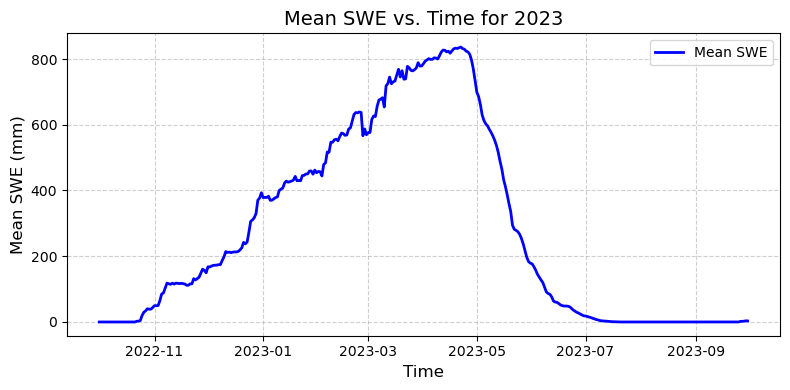

In [15]:
plot_SWE(df, YEAR)

# Step 5 Batch Processing

In [16]:
# Potential Years go from 1982 = 2023
YEAR_START = 1996
YEAR_END = 2012
years = list(range(YEAR_START, YEAR_END + 1))

boundary_path = "SkagitBoundary.json"
sf = gpd.read_file(str(boundary_path))

In [17]:
SWE_mean_df = pd.DataFrame()
for yr in years: 
    ds = download_year(yr)
    filtered_ds = crude_filter(ds, B_BOX[0], B_BOX[1], B_BOX[2], B_BOX[3]) # apply crude filter 
    filtered_ds = fine_filter(filtered_ds, sf)
    df_mean = ds_mean(filtered_ds)
    SWE_mean_df = pd.concat([SWE_mean_df, df_mean])
    
f_out = f"Skagit_{YEAR_START}_{YEAR_END}.csv"
print(f"All done, saving file {f_out}")
SWE_mean_df.to_csv(f_out)
print(SWE_mean_df.shape)
SWE_mean_df.head()

  
    

The file 4km_SWE_Depth_WY1996_v01.nc already exists, skipping download.
The file 4km_SWE_Depth_WY1997_v01.nc already exists, skipping download.
The file 4km_SWE_Depth_WY1998_v01.nc already exists, skipping download.
The file 4km_SWE_Depth_WY1999_v01.nc already exists, skipping download.
The file 4km_SWE_Depth_WY2000_v01.nc already exists, skipping download.
The file 4km_SWE_Depth_WY2001_v01.nc already exists, skipping download.
The file 4km_SWE_Depth_WY2002_v01.nc already exists, skipping download.
The file 4km_SWE_Depth_WY2003_v01.nc already exists, skipping download.
The file 4km_SWE_Depth_WY2004_v01.nc already exists, skipping download.
The file 4km_SWE_Depth_WY2005_v01.nc already exists, skipping download.
The file 4km_SWE_Depth_WY2006_v01.nc already exists, skipping download.
The file 4km_SWE_Depth_WY2007_v01.nc already exists, skipping download.
The file 4km_SWE_Depth_WY2008_v01.nc already exists, skipping download.
The file 4km_SWE_Depth_WY2009_v01.nc already exists, skipping do

,mean_SWE
time,
1995-10-01,0.278008
1995-10-02,0.329876
1995-10-03,0.454357
1995-10-04,1.883817
1995-10-05,1.562241


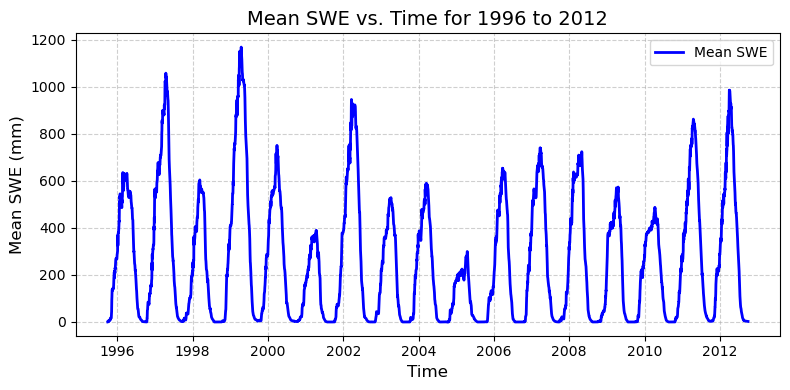

In [18]:
time_period = f"{years[0]} to {years[-1]}"
plot_SWE(SWE_mean_df, time_period)

# 